In [1]:
# import the libraries
import csv
import cv2
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
print(cv2.__version__)

3.1.0


In [2]:
n_zero_angles = 0
current_dir = "./180204-00/" 
model_name = "md180218.2.h5"
lines = [] 
image_paths = []
measurements = []
side_camera_angle_correction = 0.2


In [3]:
def add_a_pair (a_path, an_angle, path_list, angle_list):
  
    abs_angle = abs(an_angle)    

    #add the image & steering to the training set    
    path_list.append(a_path)
    angle_list.append (an_angle)
        

def load_line_data (a_line, path_list, angle_list, directory, os):
    #exclude any header lines
    if (a_line[0] == "center"):
        print(a_line)
        return
    

    #process center image
    orig_source_path = a_line[0]
    if (os == 'w'):
        f_name = orig_source_path.split('\\')[-1]  # just the file name portion for windows based files
    else:
        f_name = orig_source_path.split('/')[-1]  # just the file name portion for non-windows based files
        
    current_image_path = directory +"IMG/" + f_name
    angle = float(a_line[3])
    add_a_pair (current_image_path, angle, path_list, angle_list)
    

    #process left image
    orig_source_path = a_line[1]
    if (os == 'w'):
        f_name = orig_source_path.split('\\')[-1]  # just the file name portion for windows based files
    else:
        f_name = orig_source_path.split('/')[-1]  # just the file name portion for non-windows based files

    current_image_path = directory +"IMG/" + f_name
    angle = angle + side_camera_angle_correction
           
    add_a_pair (current_image_path, angle, path_list, angle_list)

    
    #process right image
    orig_source_path = a_line[2]
    
    if (os == 'w'):
        f_name = orig_source_path.split('\\')[-1]  # just the file name portion for windows based files
    else:
        f_name = orig_source_path.split('/')[-1]  # just the file name portion for non-windows based files
        
    current_image_path = directory +"IMG/" + f_name
    angle = angle - side_camera_angle_correction
    
    add_a_pair (current_image_path, angle, path_list, angle_list)

def add_paths_angles(directory, os):
    csv_fname = directory + "driving_log.csv"
    print(csv_fname)
    f_csv = open (csv_fname)
    print(f_csv)
    read_buffer = csv.reader(f_csv)
    
    x = 0
    for a_line in read_buffer:
        x += 1
        load_line_data (a_line, image_paths, measurements, directory, os)
        if (x % 2 == 0):
            c = '/'
        else:
            c = '\\'
        print(c,end='\r')
       
    print()
    #close the opened fileload_line_data (a_line, images, measurements, directory, os)
    f_csv.close()

In [4]:
#Load training data from current directory
#add_paths_angles(current_dir, 'w')
#add_paths_angles("./data/", 'l')
add_paths_angles("./mydata/", 'w')


./mydata/driving_log.csv
<_io.TextIOWrapper name='./mydata/driving_log.csv' mode='r' encoding='UTF-8'>
/


8280


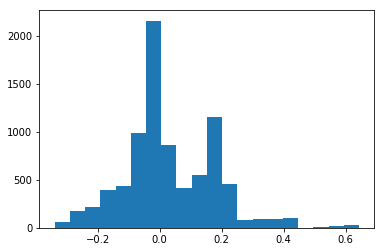

[  5.60000000e+01   1.72000000e+02   2.20000000e+02   3.96000000e+02
   4.36000000e+02   9.86000000e+02   2.15400000e+03   8.62000000e+02
   4.10000000e+02   5.54000000e+02   1.15400000e+03   4.54000000e+02
   8.50000000e+01   9.20000000e+01   9.00000000e+01   1.01000000e+02
   1.00000000e+00   1.10000000e+01   2.10000000e+01   2.50000000e+01]
8280.0


In [5]:
#Visualize the data

#plot the image
def plot_image(img):
    plt.imshow (img)
    plt.show()

def plot_histo (a_list, bins):
    print(len(a_list))
    (n,bin, patches) = plt.hist(a_list, bins)
    plt.show()
    print(n)
    print(sum(n))

plot_histo(measurements, 20)


In [6]:
#utils code needed later
def process_an_image (path, an_angle, img_list, angle_list, flip):
    
    indx = np.random.randint(7)
    abs_angle = abs(an_angle)
    if (indx % 2 == 0) & (abs_angle < 0.050):
        return
   
    if (indx % 3 == 0) & (abs_angle < 0.075):
        return
    
    if (indx % 4 == 0) & (abs_angle < 0.100):
        return
    
    if (indx % 5 == 0) & (abs_angle < 0.125):
        return

    if (indx % 7 == 0) & (abs_angle < 0.150):
        return

    if (indx % 8 == 0) & (abs_angle < 0.175):
        return

    if (indx % 9 == 0) & (abs_angle < 0.200):
        return

    an_img  = cv2.imread(path, cv2.COLOR_BGR2RGB)
    if (an_img.all() == None):
        print("None file: ", path)
        return
            
    #add the image & steering to the training set    
    img_list.append(an_img)
    angle_list.append (an_angle)
        
    
    if flip == True:
        img_list.append(np.fliplr(an_img))
        angle_list.append (-1.0 * (an_angle))

In [7]:
n_threshold = 3000
n_bins = 20
train_image = []
train_angle = []
elements = np.zeros (n_bins)  

In [8]:
#utils, functions to extract right data from master data set
def map_angle_bin (low, high, bins, angle):
    if angle < low:
        bin = 0
    elif angle > high:
        bin = bins - 1
    else:
        bin = ((angle -low)/ (high - low)) * bins
        bin = bin - 1
        
    return int(bin)

def select_training_data (m_paths, m_angle, t_image, t_angle):

    for a_path, an_angle in zip(m_paths, m_angle):
        bin = map_angle_bin (-1.0, 1.0, n_bins, an_angle)
        if (elements[bin] < n_threshold):
            print("*", end='\r')
            an_img  = cv2.imread(a_path)
            an_img  = cv2.cvtColor(an_img, cv2.COLOR_BGR2RGB)
            if (an_img.all() == None):
                print("None file: ", path)
                continue
                
            t_image.append(an_img)   #load the image
            t_angle.append(an_angle)
        
            elements[bin] += 1
        else:
            continue
    return


In [9]:
image_paths, measurements = shuffle (image_paths, measurements)
print(image_paths[0], measurements[0])

./mydata/IMG/left_2018_02_18_13_16_20_845.jpg 0.2


In [10]:
image_paths, measurements = shuffle (image_paths, measurements)
select_training_data (image_paths, measurements, train_image, train_angle)

Num of training images 8280
8280


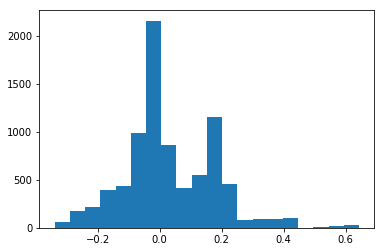

[  5.60000000e+01   1.72000000e+02   2.20000000e+02   3.96000000e+02
   4.36000000e+02   9.86000000e+02   2.15400000e+03   8.62000000e+02
   4.10000000e+02   5.54000000e+02   1.15400000e+03   4.54000000e+02
   8.50000000e+01   9.20000000e+01   9.00000000e+01   1.01000000e+02
   1.00000000e+00   1.10000000e+01   2.10000000e+01   2.50000000e+01]
8280.0
Elements info
8280.0
[    0.     0.     0.     0.     0.    40.   358.   828.  1811.  2632.
  1052.  1218.   182.   102.    32.    25.     0.     0.     0.     0.]


In [11]:

print ("Num of training images {}".format(len(train_image)))
plot_histo(train_angle, n_bins)

print("Elements info")
print(sum(elements))
print(elements)

In [12]:
augment_images = []
augment_angles  = []
low_thr = -0.1
high_thr = 0.1
for an_image, an_angle in zip (train_image, train_angle):
    if (an_angle > low_thr) and (an_angle < high_thr):
        continue
    
    #flip the image and angle
    aug_image = np.fliplr(an_image)
    aug_angle = -1.0 * an_angle
    
    augment_images.append(aug_image)
    augment_angles.append(aug_angle)

print(len(augment_angles), len(augment_images))

3837 3837


In [13]:
X_train = np.array(train_image)
y_train = np.array(train_angle)
    
print("X_train shape {}, y_train.shape {}".format(X_train.shape, y_train.shape))

X_aug = np.array(augment_images)
y_aug = np.array(augment_angles)
    
print("X_aug shape {}, y_aug.shape {}".format(X_aug.shape, y_aug.shape))

X_train shape (8280, 160, 320, 3), y_train.shape (8280,)
X_aug shape (3837, 160, 320, 3), y_aug.shape (3837,)


In [14]:
X_train = np.concatenate((X_train, X_aug), axis = 0)
y_train = np.concatenate((y_train, y_aug), axis = 0)

print("After augmentation: X_train shape {}, y_train.shape {}".format(X_train.shape, y_train.shape))

After augmentation: X_train shape (12117, 160, 320, 3), y_train.shape (12117,)


12117


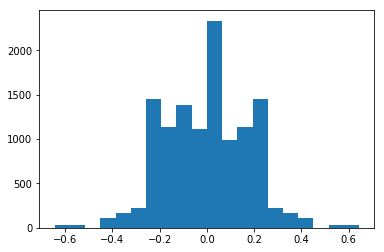

[  2.70000000e+01   2.90000000e+01   2.00000000e+00   1.08000000e+02
   1.64000000e+02   2.26000000e+02   1.45300000e+03   1.14100000e+03
   1.38600000e+03   1.11200000e+03   2.33300000e+03   9.86000000e+02
   1.14100000e+03   1.45300000e+03   2.26000000e+02   1.64000000e+02
   1.08000000e+02   2.00000000e+00   2.90000000e+01   2.70000000e+01]
12117.0


In [15]:
plot_histo(y_train, n_bins)

In [16]:
img_shape = X_train.shape
print(img_shape)
print (img_shape[1:])
IMG_SHAPE = img_shape[1:]

(12117, 160, 320, 3)
(160, 320, 3)


4673


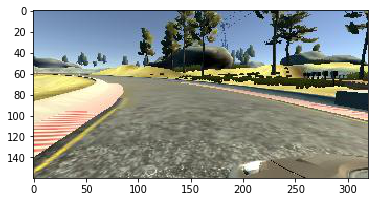

angle: 0.012030100000000016


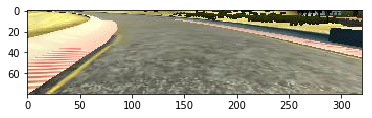

11011


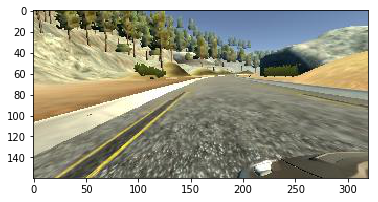

angle: -0.112782


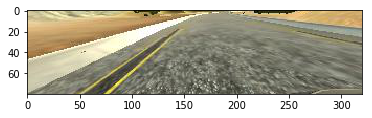

6742


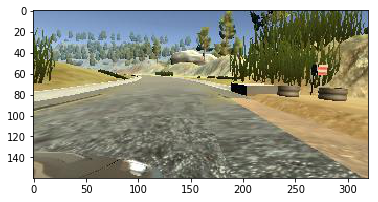

angle: -0.1278196


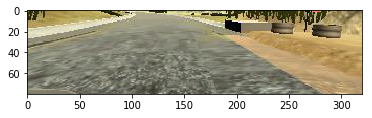

3333


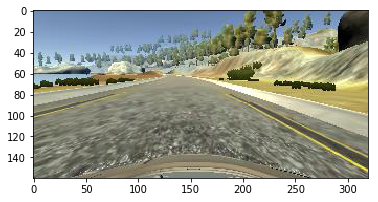

angle: 0.0


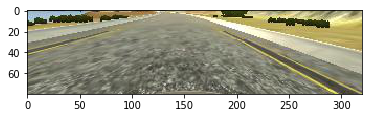

11765


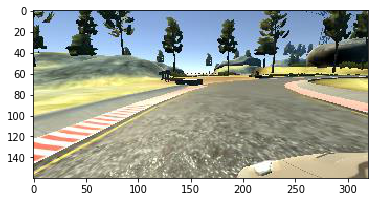

angle: 0.1804511


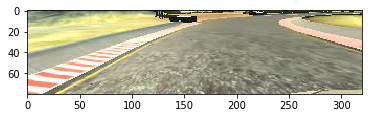

11722


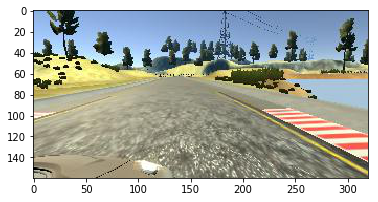

angle: -0.2


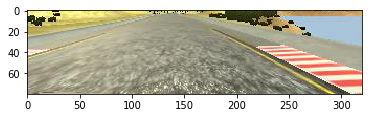

1068


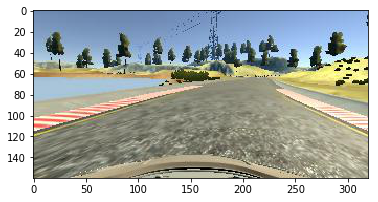

angle: 0.2030075


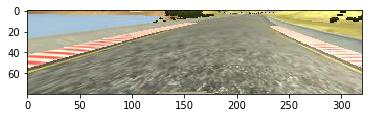

In [17]:
for i in range(7):
    indx = np.random.randint(y_train.shape[0])
    print(indx)
    image = X_train[indx, :, :, :]
    plot_image(image)
    print("angle: {}".format(y_train[indx]))

    plot_image(image[60:140,:,:])
    

In [18]:
#Create and train the model.
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Cropping2D, AveragePooling2D
from keras.layers import Dropout, Flatten, Dense

from keras.callbacks import ModelCheckpoint
print(keras.__version__)

Using TensorFlow backend.


1.2.1


In [19]:
### Define your architecture here.
### TODO: Define your architecture.
n_filters1 = 24
krnl_sz1 = 5                ## kernel size for convolutions - smaller better for better localization.
padding1 = 'valid'
activation1 = 'elu'
dropout1 = 0.5
pool_sz1 = 2

n_filters2 = 36
krnl_sz2 = 5                ## kernel size for convolutions - smaller better for better localization.
padding2 = 'valid'
activation2 = 'elu'
dropout2 = 0.4

n_filters2 = 48
krnl_sz2 = 5                ## kernel size for convolutions - smaller better for better localization.
padding2 = 'valid'
activation2 = 'elu'
dropout2 = 0.3
pool_sz2 = 2

n_filters3 = 64
krnl_sz3 = 5                ## kernel size for convolutions - smaller better for better localization.
padding3 = 'valid'
activation3 = 'elu'
dropout3 = 0.3
pool_sz3 = 2

n_nodes4 = 64
activation4 = 'elu'
dropout4 = 0.3

n_nodes5 = 32
activation5 = 'elu'
dropout5 = 0.3

n_nodes6 = 16
activation6 = 'elu'
dropout6 = 0.3

n_classes= 1             ## output classes - nornalized  x, y positions of each feature point x 15


#start with input layer with normalization of mean = 0 and range [-0.5: 0.5]
model = Sequential()
model.add(Cropping2D(cropping=((60, 20), (0, 0)), input_shape= IMG_SHAPE))
model.add(Lambda(lambda x: x / 255.0 - 0.5))

#Take NVIDIA paper suggested architecture as per 
# https://devblogs.nvidia.com/deep-learning-self-driving-cars/


## Layer 1
##  Define the first 2D convolutional layer with proper input shape and 32 filters to start with, relu activation.
model.add(Convolution2D(n_filters1,krnl_sz1 ,krnl_sz1, border_mode=padding1, activation = activation1))
model.add(AveragePooling2D(pool_size= (pool_sz1, pool_sz1))) ## Add pooling layer
model.add(Dropout(dropout1))    ## dropout reduces the risk of overfitting.


## Layer 2
model.add(Convolution2D(n_filters2,krnl_sz2 ,krnl_sz2, border_mode=padding2, activation = activation2))
model.add(AveragePooling2D(pool_size= (pool_sz2, pool_sz2)))
model.add(Dropout(dropout2))    ## dropout reduces the risk of overfitting.

## Layer 3
model.add(Convolution2D(n_filters3,krnl_sz3 ,krnl_sz3, border_mode=padding3, activation = activation3))
model.add(AveragePooling2D(pool_size= (pool_sz3, pool_sz3)))
model.add(Dropout(dropout3))    ## dropout reduces the risk of overfitting.


# Flatten => RELU layers
model.add(Flatten())

### Layer 4
#model.add(Dense(n_nodes4, activation= activation4))
model.add(Dense(n_nodes4))
model.add(Dropout(dropout4)) ## Add strong drop out rate at this later stage.

### Layer 5
#model.add(Dense(n_nodes5, activation= activation5))
model.add(Dense(n_nodes5))
#model.add(Dropout(dropout5)) ## Add strong drop out rate at this later stage.

### Layer 6
#model.add(Dense(n_nodes6, activation= activation6))
model.add(Dense(n_nodes6))
#model.add(Dropout(dropout6)) ## Add strong drop out rate at this later stage.

### Layer 7
model.add(Dense(n_classes))

# Summarize the model
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 80, 320, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 80, 320, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 76, 316, 24)   1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
averagepooling2d_1 (AveragePooli (None, 38, 158, 24)   0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [20]:
N_EPOCHS = 7

In [21]:
## TODO: Compile the model
model.compile(loss ='mse',optimizer='adam', metrics = ['accuracy'])

b_weights_load = True
 
if (b_weights_load == True):
    model.load_weights("./weights.hd5")
    
## TODO: Train the model
checkpointer = ModelCheckpoint(filepath='./weights.hdf5', verbose=1, save_best_only = False)

# TODO: Run the model. Feel free to experiment with different batch sizes and number of epochs.
hist = model.fit(X_train, y_train, nb_epoch = N_EPOCHS, shuffle = True, callbacks=[checkpointer], verbose=1, validation_split=0.2)


#hist = model.fit(X_train, y_train, nb_epoch = N_EPOCHS, shuffle = True, verbose=1, validation_split=0.2)

#save model
model.save (model_name)

Train on 9693 samples, validate on 2424 samples
Epoch 1/7
9693/9693 [==============================] - 61s - loss: 0.0244 - acc: 0.1391 - val_loss: 0.0172 - val_acc: 0.0000e+00
Epoch 2/7
9693/9693 [==============================] - 58s - loss: 0.0098 - acc: 0.1401 - val_loss: 0.0120 - val_acc: 0.0000e+00
Epoch 3/7
9693/9693 [==============================] - 58s - loss: 0.0082 - acc: 0.1401 - val_loss: 0.0141 - val_acc: 0.0000e+00
Epoch 4/7
9693/9693 [==============================] - 58s - loss: 0.0073 - acc: 0.1401 - val_loss: 0.0101 - val_acc: 0.0000e+00
Epoch 5/7
9693/9693 [==============================] - 58s - loss: 0.0067 - acc: 0.1401 - val_loss: 0.0087 - val_acc: 0.0000e+00
Epoch 6/7
9693/9693 [==============================] - 58s - loss: 0.0063 - acc: 0.1401 - val_loss: 0.0088 - val_acc: 0.0000e+00
Epoch 7/7
9693/9693 [==============================] - 58s - loss: 0.0061 - acc: 0.1401 - val_loss: 0.0076 - val_acc: 0.0000e+00


dict_keys(['loss', 'val_loss', 'val_acc', 'acc'])


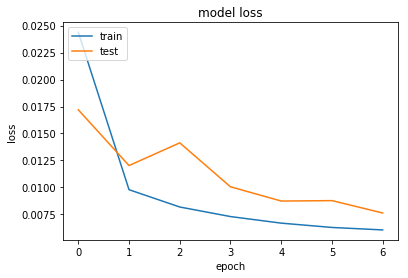

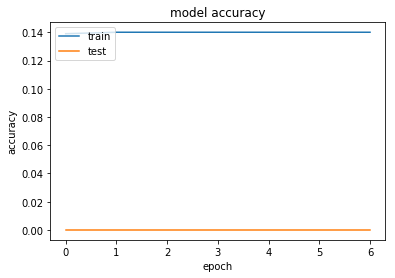

In [22]:
# list all data in history
print(hist.history.keys())

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

